# It's FIRE in reverse
Track back formation locations in FIRE

In [215]:
import os
from multiprocessing import Pool

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi

import astropy.units as u
from tqdm import tqdm
import pandas as pd

import sys
sys.path.append("helpers")

from importlib import reload

import tomFIRE

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load in the data

In [170]:
reload(tomFIRE)
recent_stars = tomFIRE.FIRESnapshot(particle_type="star", min_t_form=13.6 * u.Gyr)
recent_stars

<FIRESnapshot | 9660 star particles | R < 30.0 kpc & t_form > 13.6 Gyr>

In [4]:
pot = gp.load("m11h_potential.yml")

# Quick test of orbit generation

In [211]:
w0 = gd.PhaseSpacePosition(pos=recent_stars.X_s, vel=recent_stars.V_s)
orbits = pot.integrate_orbit(w0[:20], dt=-1 * u.Myr, n_steps=1000)

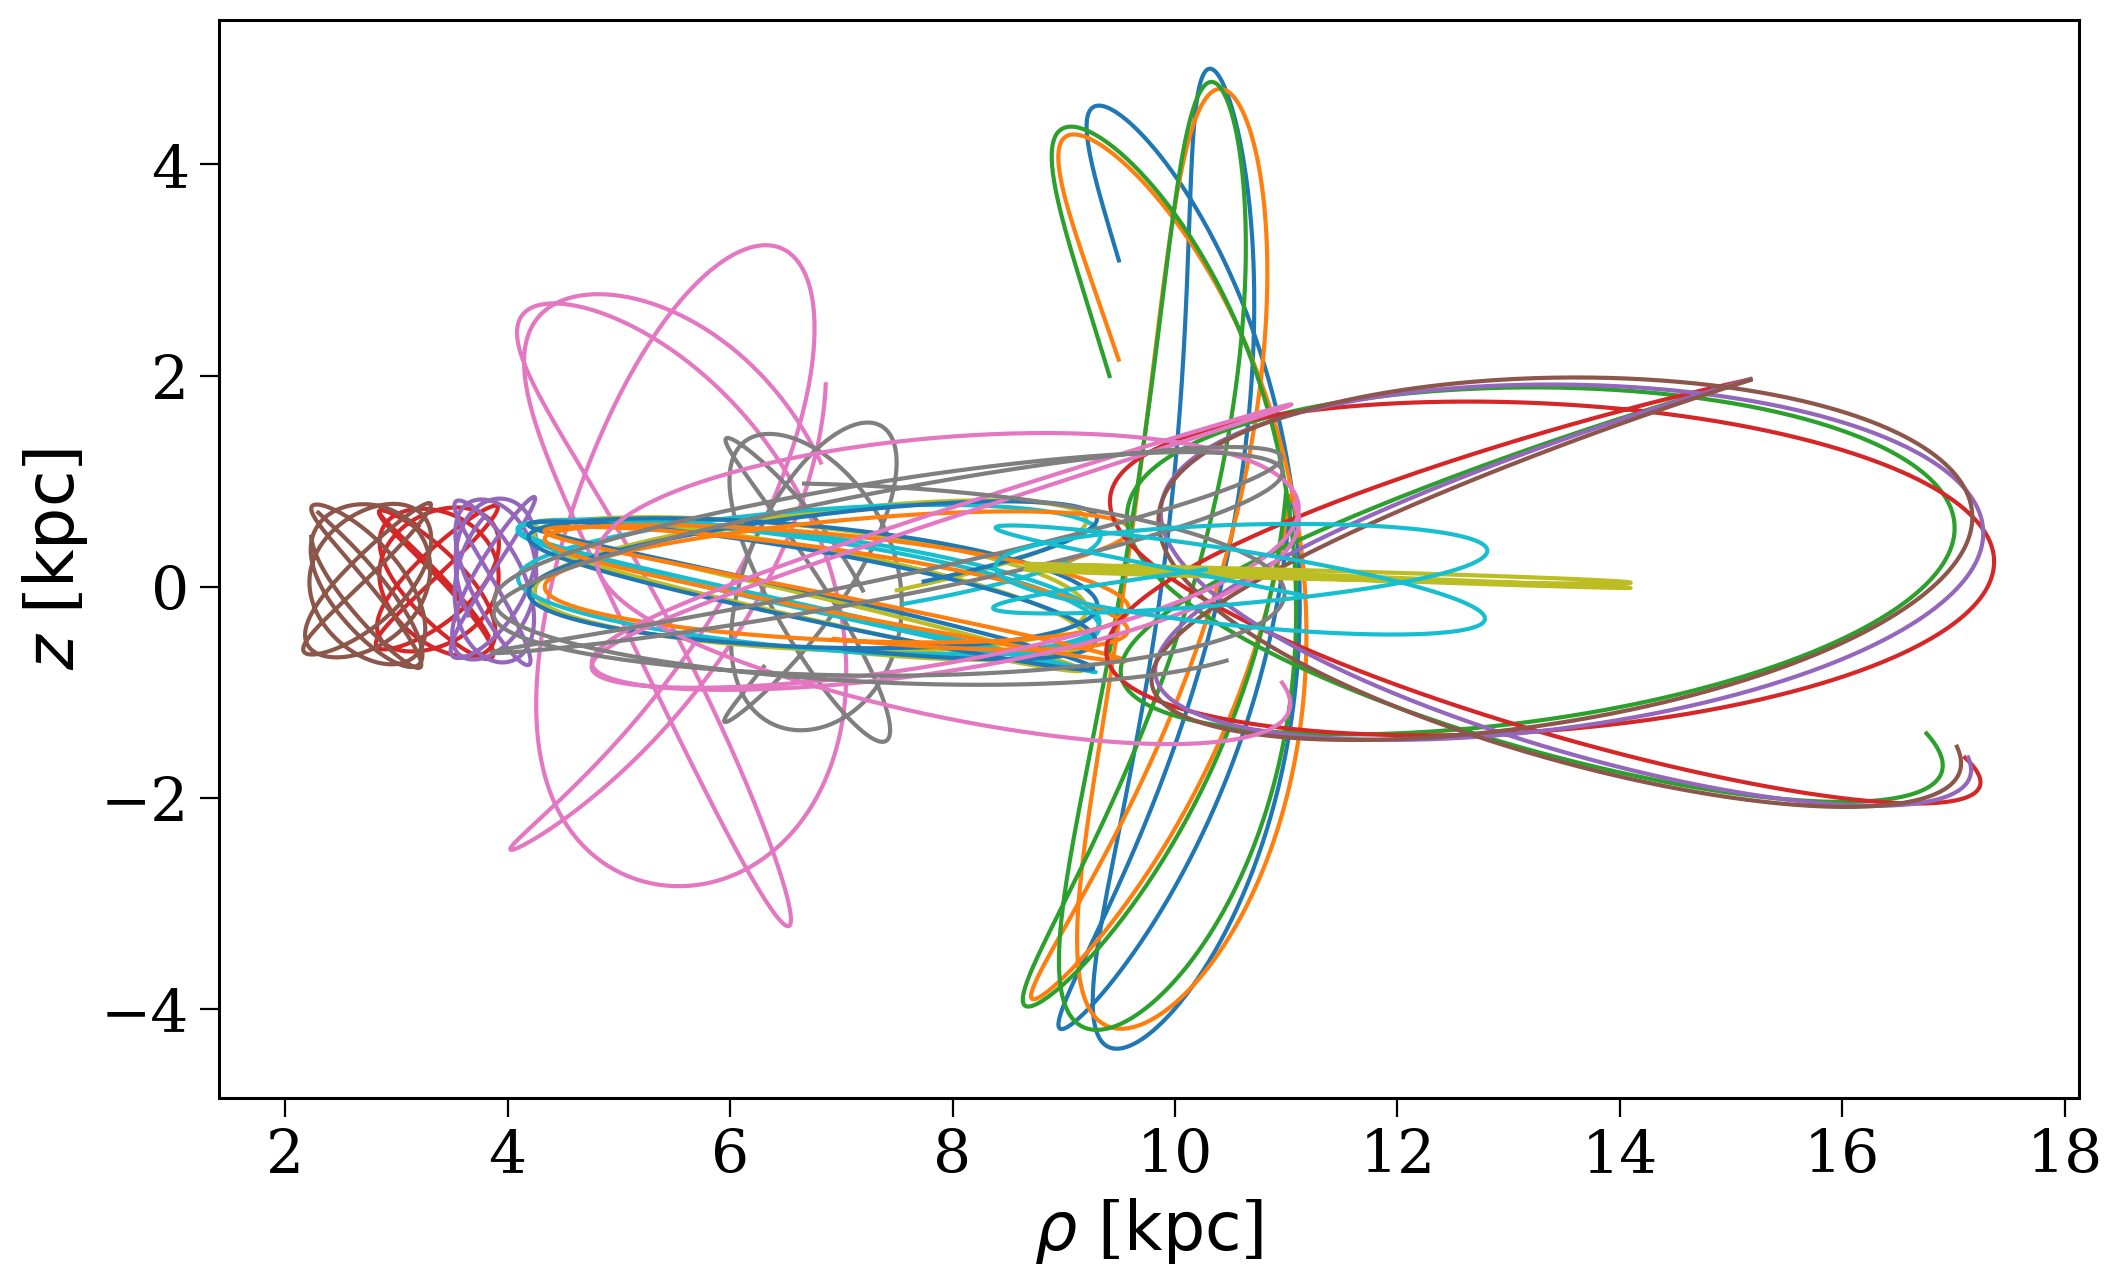

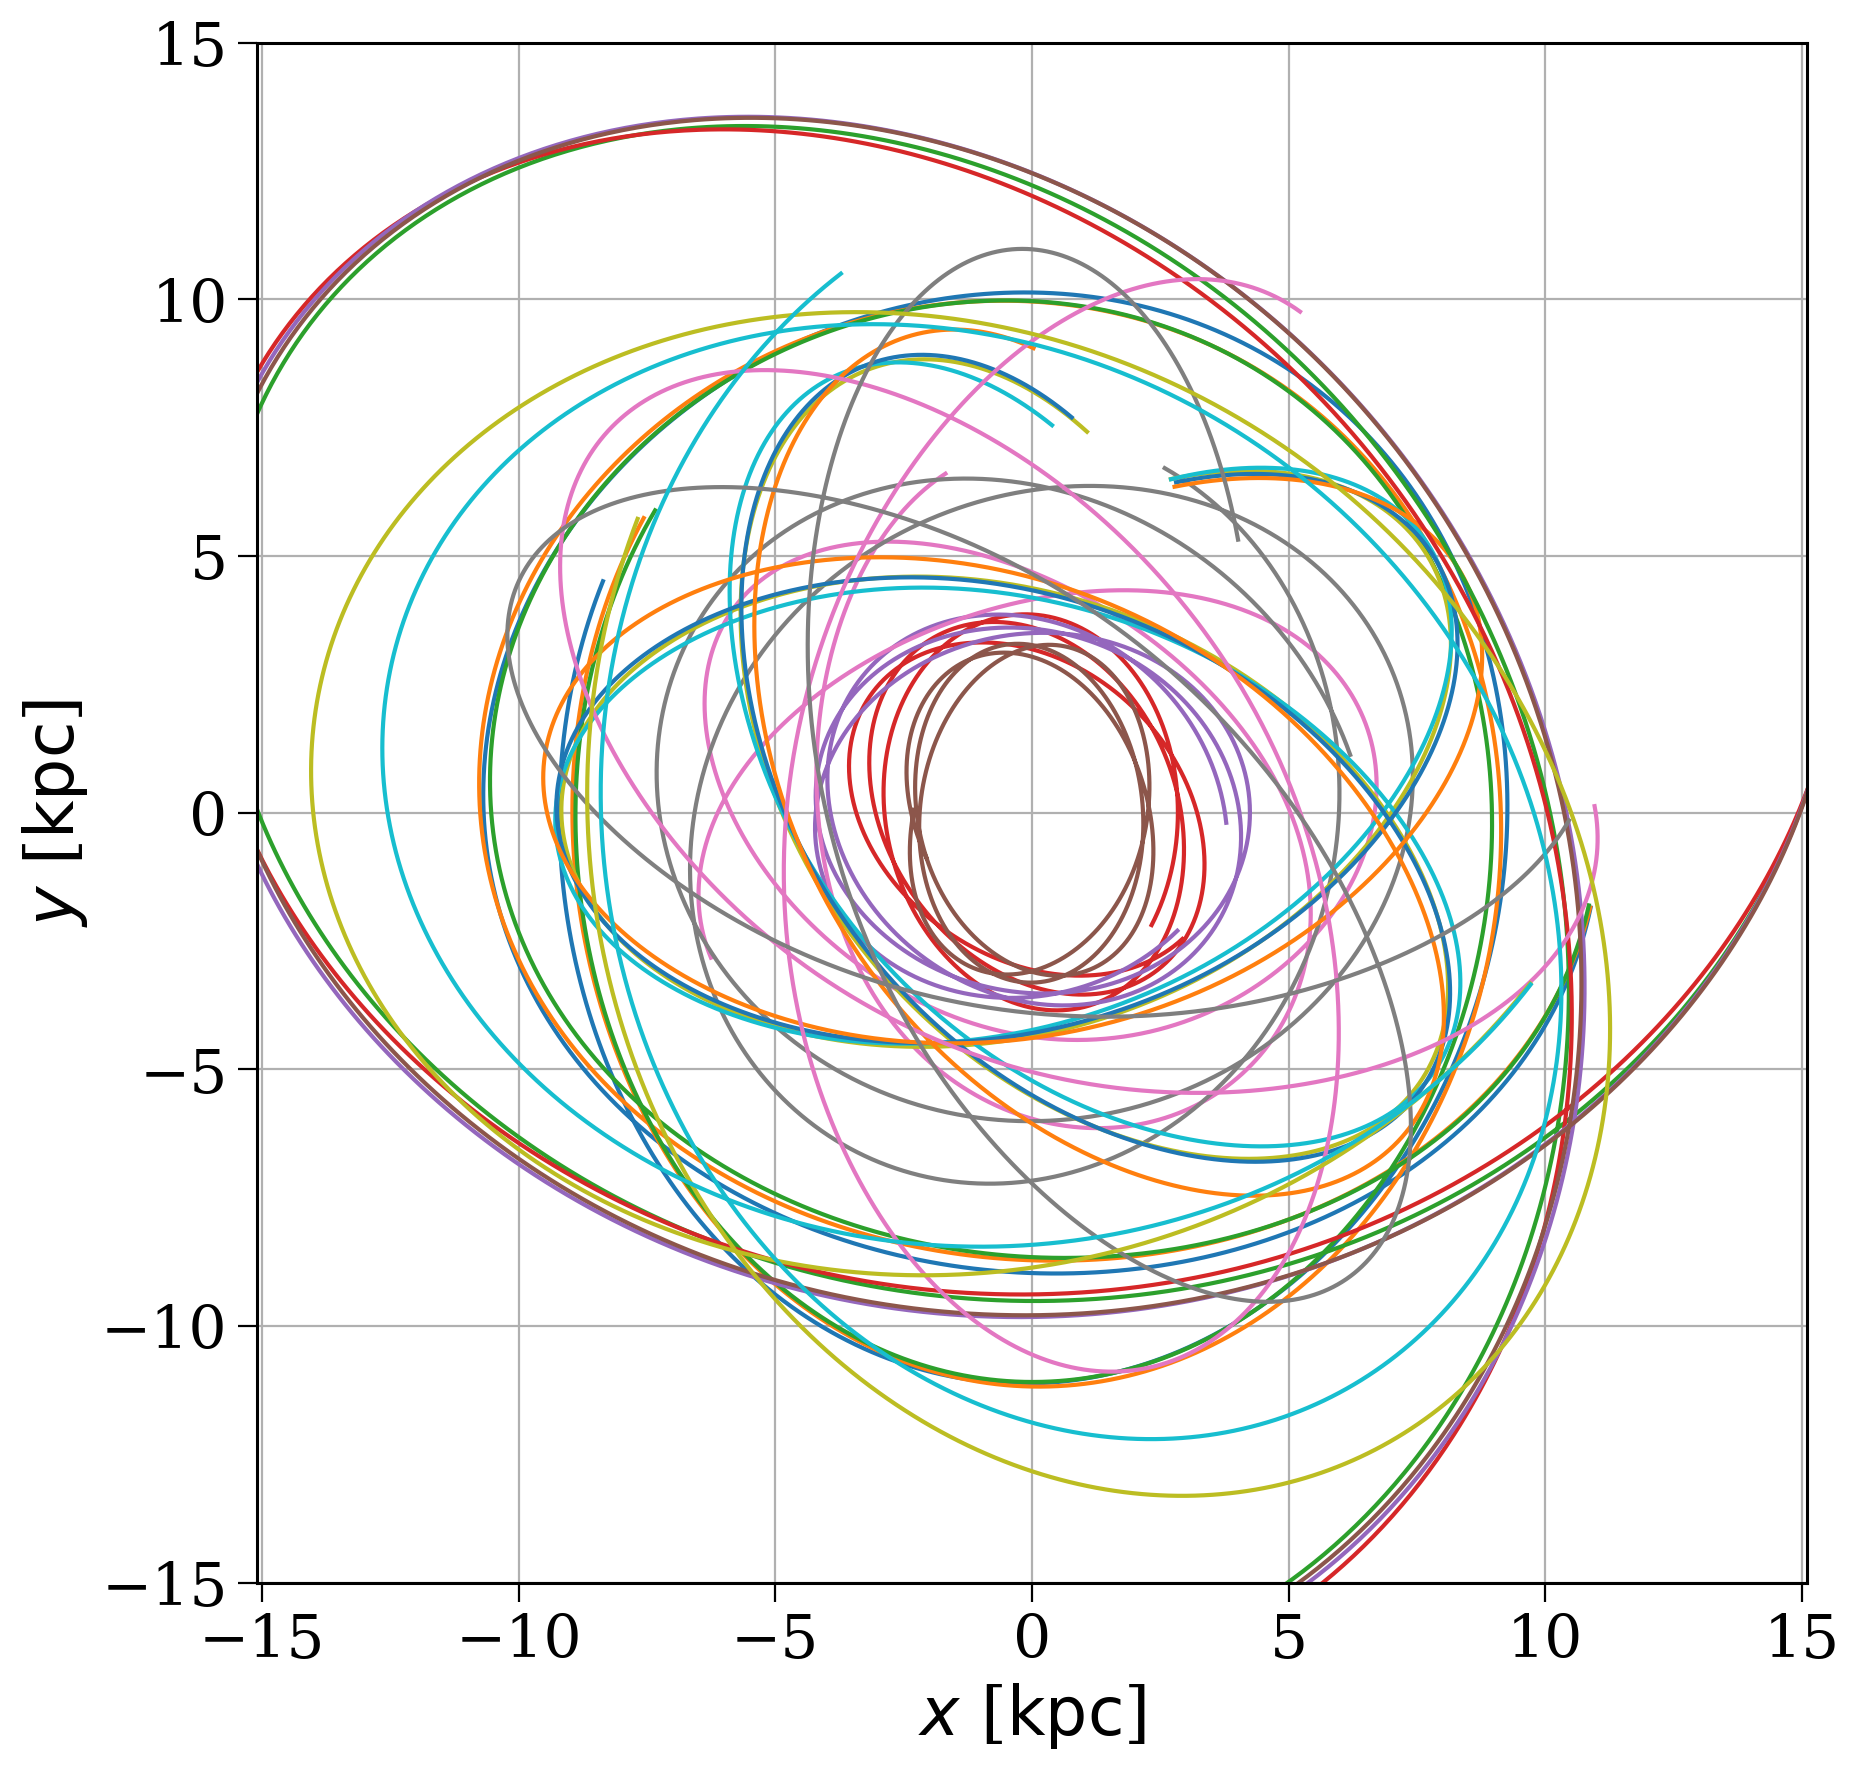

In [214]:
fig, ax = plt.subplots(figsize=(12, 7))
orbits.cylindrical.plot(["rho", "z"], axes=[ax])
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
orbits.plot(["x", "y"], axes=[ax])
ax.set_aspect("equal")
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
ax.grid()
plt.show()

# Actual reverse integration

In [112]:
def reverse_engineer(w0, t2):
    return pot.integrate_orbit(w0, t1=recent_stars.snap_time, t2=t2, dt=-1 * u.Myr, Integrator=gi.DOPRI853Integrator)[-1]

In [113]:
pool = Pool(4)
args = [(w0[i], recent_stars.t_form[i]) for i in range(len(recent_stars))]
wf = pool.starmap(reverse_engineer, tqdm(args, total=len(args)))
pool.close()
pool.join()

100%|██████████| 9660/9660 [05:12<00:00, 30.91it/s]   


In [117]:
initial_star_particles = np.zeros((len(recent_stars), 9))
initial_star_particles[:, 0] = recent_stars.m.to(u.Msun).value
initial_star_particles[:, 1] = recent_stars.Z
initial_star_particles[:, 2] = recent_stars.t_form.to(u.Gyr).value

for i in range(len(wf)):
    initial_star_particles[i, 3:6] = wf[i].xyz.to(u.kpc).value
    initial_star_particles[i, 6:9] = wf[i].vel.d_xyz.to(u.km / u.s).value

In [125]:
df = pd.DataFrame(initial_star_particles, columns=["mass", "Z", "t_form", "x", "y", 'z', 'v_x', 'v_y', 'v_z'])

In [322]:
df.to_hdf("FIRE_star_particles.h5", key="df")

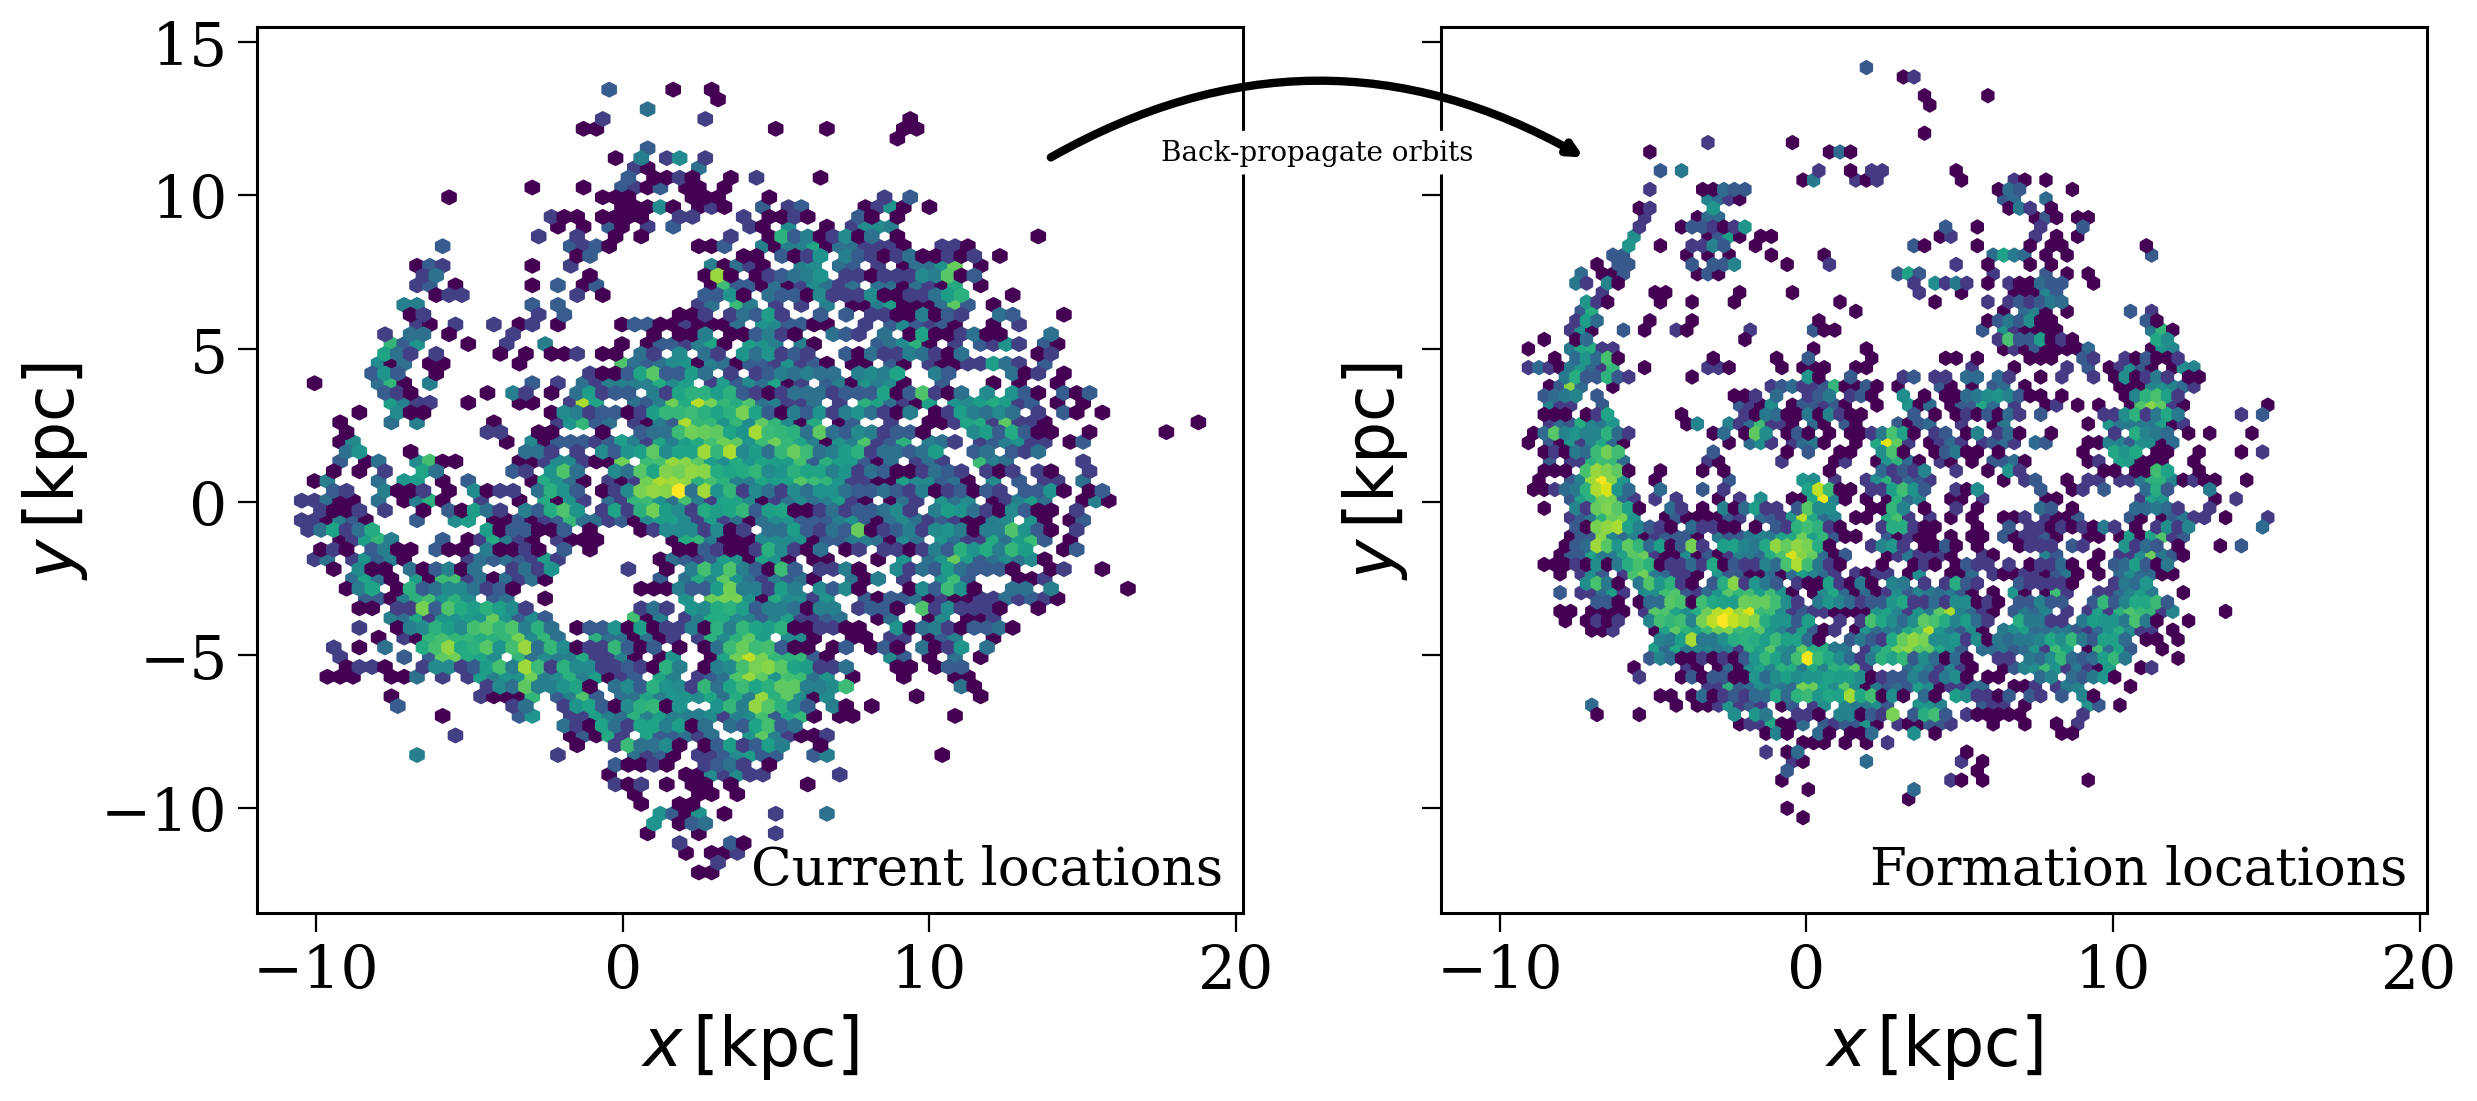

In [282]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

axes[0].hexbin(recent_stars.x, recent_stars.y, norm=mpl.colors.LogNorm(), gridsize=70)
axes[0].set_aspect("equal")
axes[0].annotate("Current locations", xy=(0.98, 0.02), xycoords="axes fraction",
                 ha="right", va="bottom", fontsize=0.8*fs)

axes[1].hexbin(df["x"], df["y"], norm=mpl.colors.LogNorm(), gridsize=70)
axes[1].set_aspect("equal")
axes[1].annotate("Formation locations", xy=(0.98, 0.02), xycoords="axes fraction",
                 ha="right", va="bottom", fontsize=0.8*fs)

for ax in axes:
    ax.set_xlabel(r"$x \, [\rm kpc]$")
    ax.set_ylabel(r"$y \, [\rm kpc]$")

axes[1].annotate("", xytext=(-0.4, 0.85), xy=(0.15, 0.85), xycoords="axes fraction", arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3, angleA=30, angleB=-30", lw=3, color='black'), zorder=100)
axes[1].annotate("Back-propagate orbits", xy=(-0.125, 0.85), xycoords="axes fraction", ha="center", bbox=dict(boxstyle="round", ec='none', fc='white'))

plt.show()

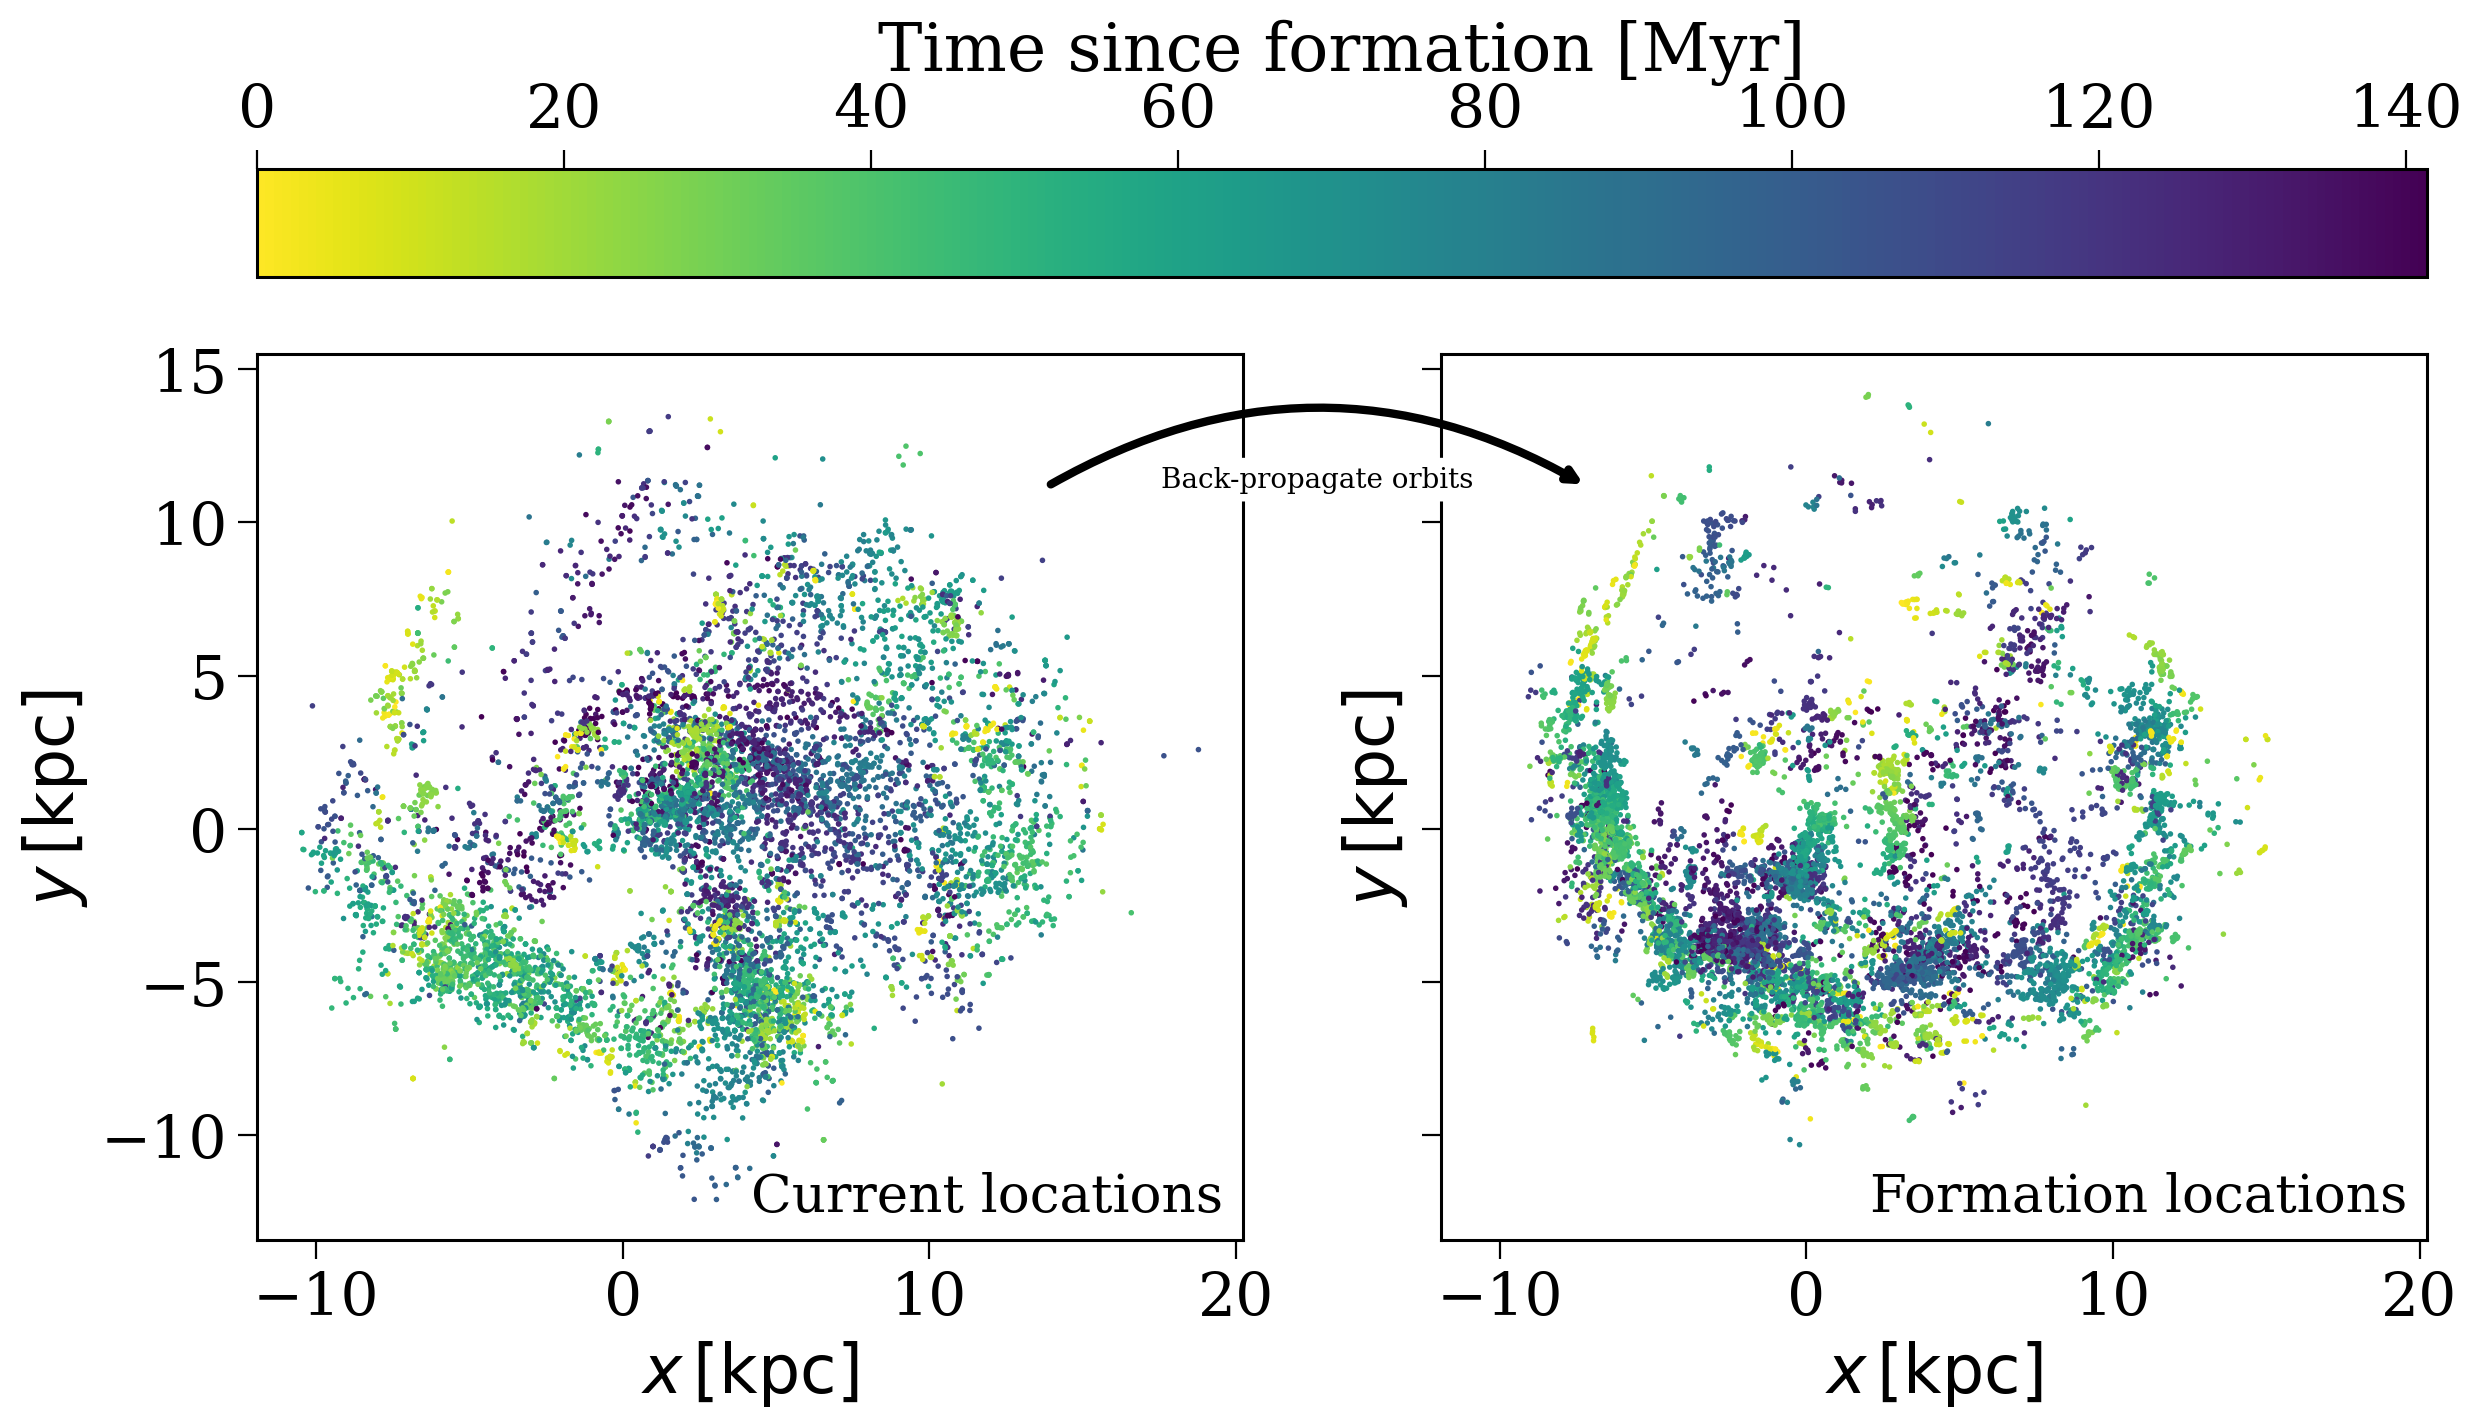

In [319]:
fig, axes = plt.subplots(1, 2, figsize=(14, 10), sharex=True, sharey=True)

axes[0].scatter(recent_stars.x, recent_stars.y, c=(recent_stars.snap_time.value - recent_stars.t_form.value) * 1000, s=1, vmin=0.0, cmap="viridis_r")
axes[0].set_aspect("equal")
axes[0].annotate("Current locations", xy=(0.98, 0.02), xycoords="axes fraction",
                 ha="right", va="bottom", fontsize=0.8*fs)

scatter = axes[1].scatter(df["x"], df["y"], c=(recent_stars.snap_time.value - df["t_form"].values) * 1000, s=1, vmin=0.0, cmap="viridis_r")
axes[1].set_aspect("equal")
axes[1].annotate("Formation locations", xy=(0.98, 0.02), xycoords="axes fraction",
                 ha="right", va="bottom", fontsize=0.8*fs)

for ax in axes:
    ax.set_xlabel(r"$x \, [\rm kpc]$")
    ax.set_ylabel(r"$y \, [\rm kpc]$")

axes[1].annotate("", xytext=(-0.4, 0.85), xy=(0.15, 0.85), xycoords="axes fraction", arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3, angleA=30, angleB=-30", lw=3, color='black'), zorder=100)
axes[1].annotate("Back-propagate orbits", xy=(-0.125, 0.85), xycoords="axes fraction", ha="center", bbox=dict(boxstyle="round", ec='none', fc='white'))

fig.colorbar(scatter, ax=axes, orientation="horizontal", location="top", label="Time since formation [Myr]")

plt.show()

## Sanity checks

In [198]:
dist = np.sqrt((recent_stars.x.value - df["x"].values)**2 + (recent_stars.y.value - df["y"].values)**2 + (recent_stars.z.value - df["z"].values)**2) * u.kpc
lookback_time = (np.abs(df["t_form"].values - 13.74) * u.Gyr).to(u.Myr)

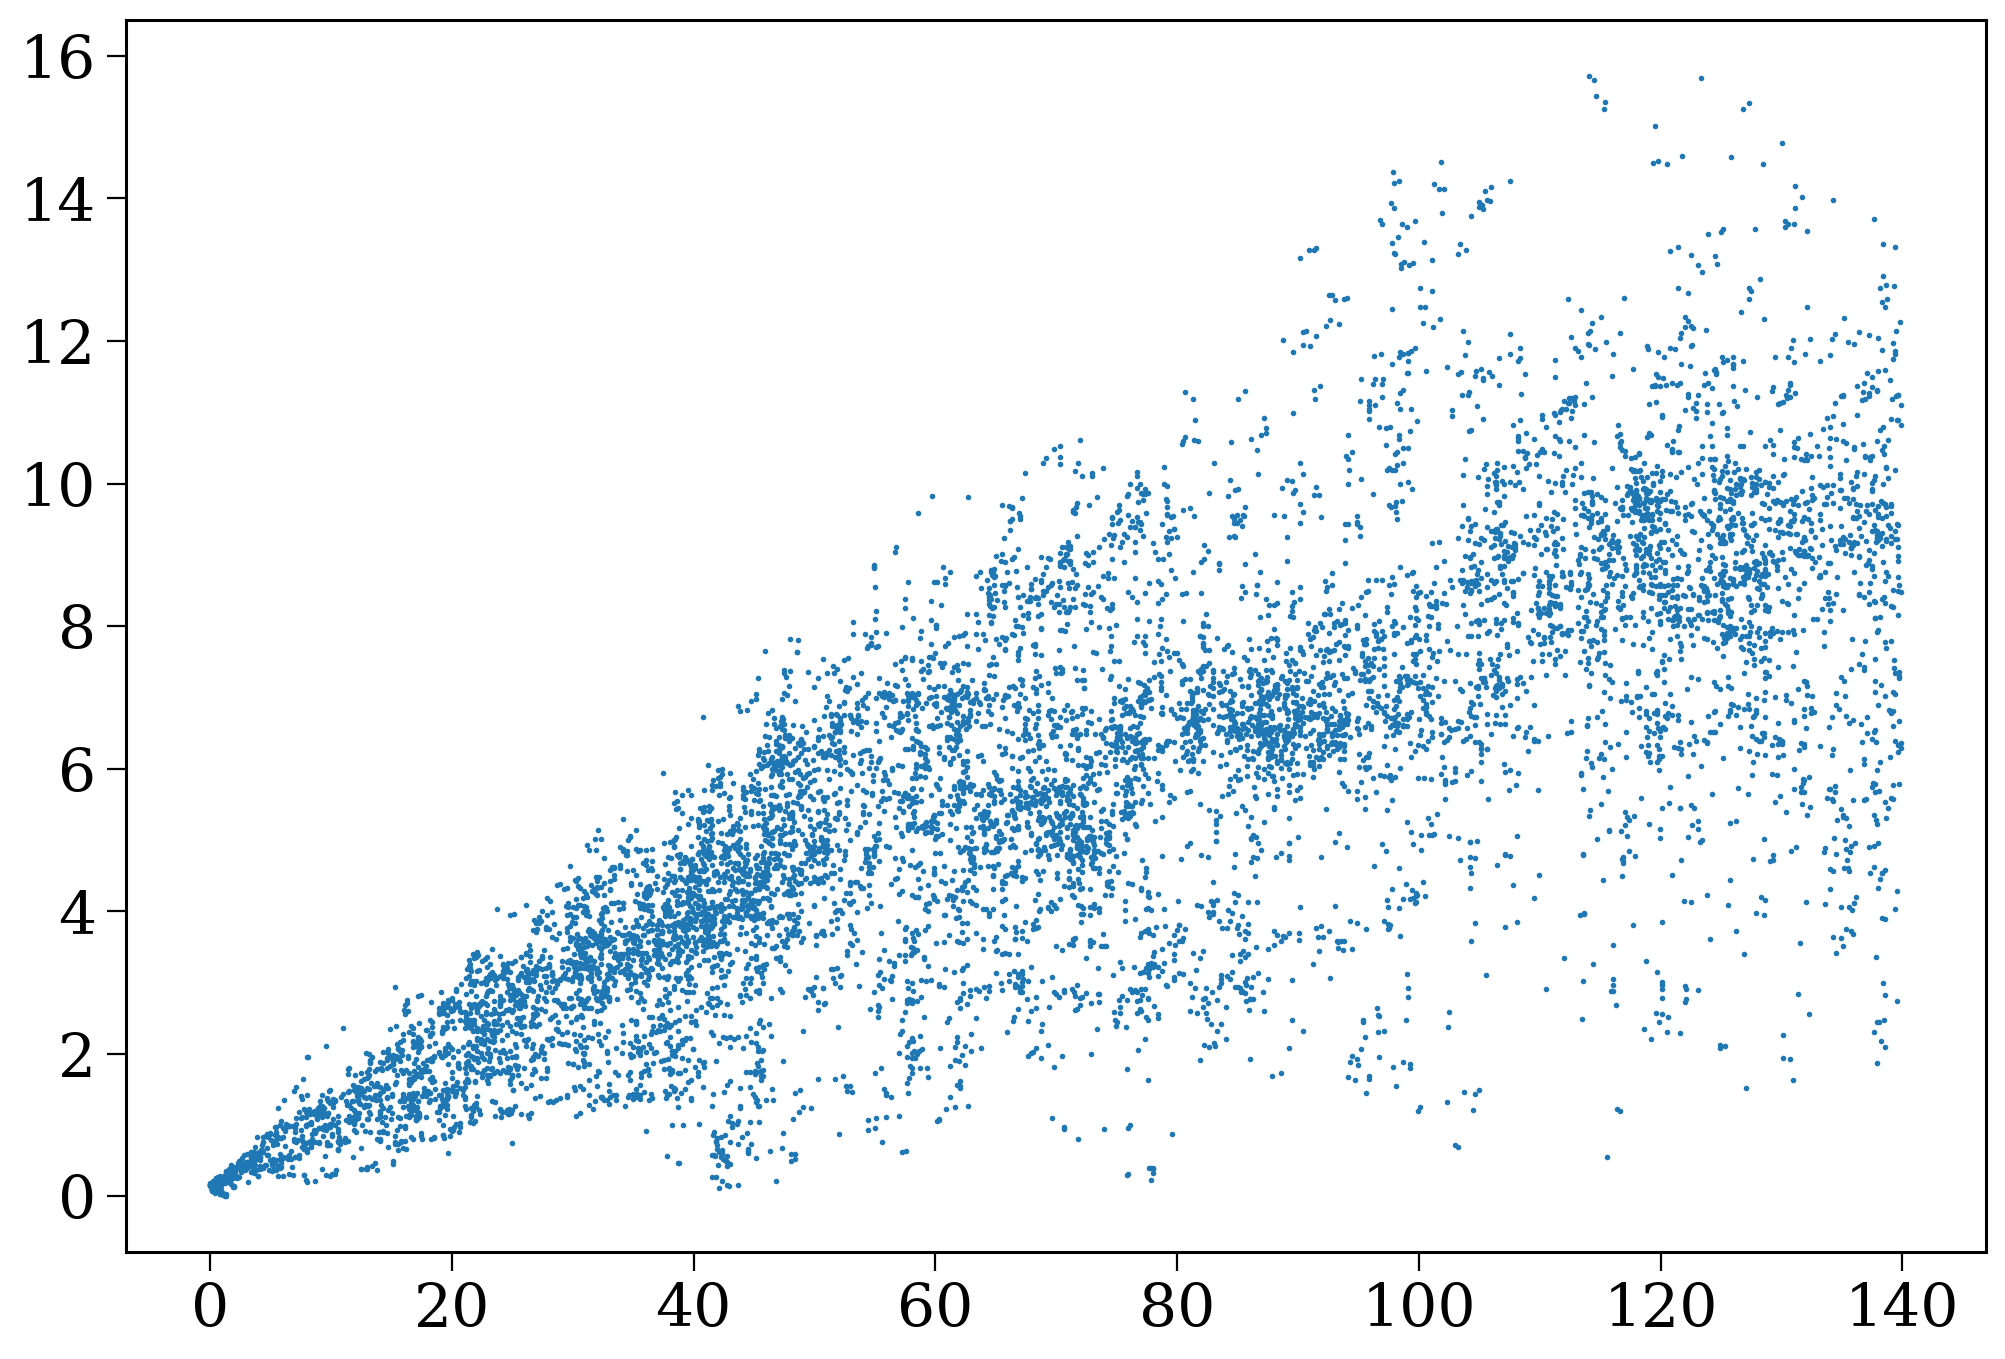

In [200]:
plt.scatter(lookback_time, dist, s=1)

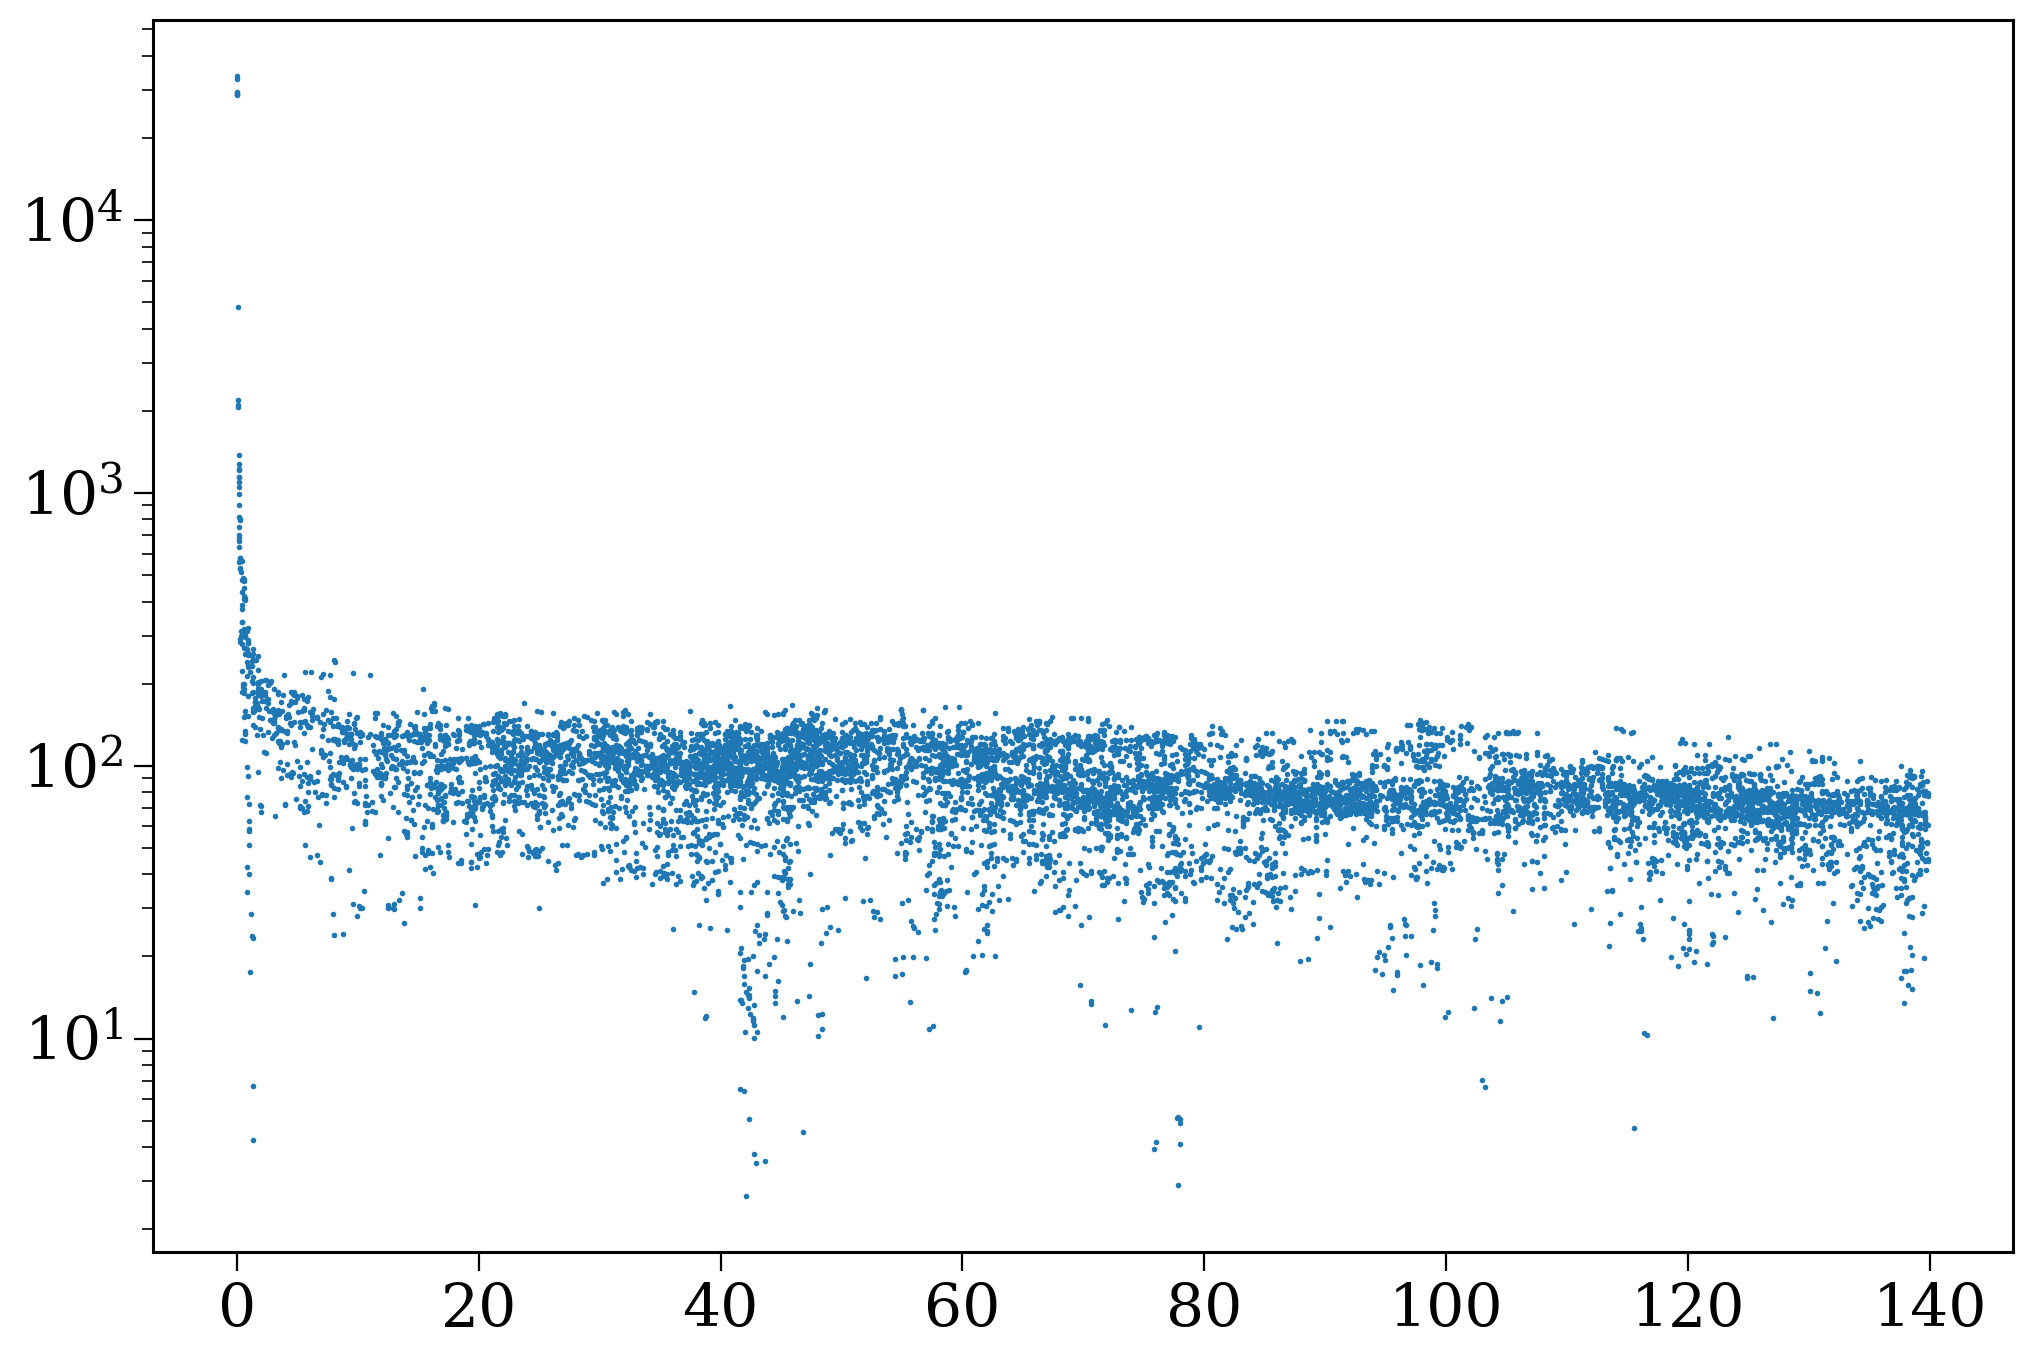

In [201]:
plt.scatter(lookback_time, average_v, s=1)
plt.yscale("log")

In [ ]:
with h5.File("/mnt/home/chayward/firesims/fire2/public_release/core/m11h_res7100/output/snapshot_600.hdf5") as f:
    star_ids = f["PartType4"]["ParticleIDs"][...]

    print(f["PartType4"].keys())

    print(f["PartType4"]["ParticleIDs"][...])

    print(any(np.isin(star_ids, f["PartType0"]["ParticleIDs"][...])))
    print(f["PartType0"]["ParticleIDs"][...])
    print((f["PartType4"]["ParticleIDGenerationNumber"][...] > 0).sum())
    print((f["PartType4"]["ParticleChildIDsNumber"][...] > 0).sum())

<KeysViewHDF5 ['Coordinates', 'Masses', 'Metallicity', 'ParticleChildIDsNumber', 'ParticleIDGenerationNumber', 'ParticleIDs', 'StellarFormationTime', 'Velocities']>
[10846552  5726876  6569263 ... 10228823  7485095  7489158]
False
[2590791 2203083 3465701 ... 3157141 3585573 3064392]
0
0
